In [24]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import basinhopping
import skimage
import IPython.display as disp
from math import floor

In [25]:
DATASET_PATH = "/home/quesneay/mohit/final/dataset_cat/separated/mask/"
# DATASET_PATH = "/home/aymeric/OMA/projet_rech/dataset/mask/"

In [26]:
def display_progress(i, maxi, length):
    """Helper function to display progress during large computations"""
    disp.display('[' + "".join(
        ['=' for j in range(floor(length*i/maxi))]
    ) + '>' + "".join(
        [' ' for j in range(floor(length*i/maxi)+1, length)]
    ) + ']', str(floor(length*i/maxi)), '%')
    disp.clear_output(wait=True)

In [27]:
from os import listdir

file_list = listdir(DATASET_PATH)
CoMs = {}

In [28]:
from skimage.measure import find_contours, moments
from scipy.ndimage import binary_fill_holes

def find_centers_of_mass(img, thresh=5000):
    contours = find_contours(img, level=0.5)
    centers_of_mass = []
    for i, contour in enumerate(contours):
        int_contour = np.ceil(contour).astype('uint16')
        mat = np.zeros(img.shape)
        mat[int_contour[:,0], int_contour[:,1]] = 1
        bin_holes = binary_fill_holes(mat)
        m = moments(bin_holes)
        # Threshold removes small blobs that are artifacts from
        # a possible erosion prior to the processing
        if m[0,0] > thresh:
            x = int(m[0,1]/m[0,0])
            y = int(m[1,0]/m[0,0])
            centers_of_mass.append((x, y))
    return centers_of_mass

In [29]:
from json import dumps, load
from pathlib import Path

## Loads precomputed centers of mass if the corresponding file exists
## Otherwise, compute the centers of mass.

if Path("centers_of_mass.json").exists():
    with open("centers_of_mass.json", 'r') as coms_fd:
        CoMs = load(coms_fd)
        print('Loaded centers of mass from file.')
else:
    for i, file in enumerate(file_list):
        img = plt.imread(DATASET_PATH + '/' + file)[:,:,0]
        CoMs[file] = find_centers_of_mass(img)
        display_progress(i, len(file_list), 50)
    with open("centers_of_mass.json", 'w') as fd:
        fd.write(dumps(CoMs))
        

# Compute set of example that have 32 teeth and examples that have less than 32
_32_teeth = []
not_32_teeth = []
for key in CoMs.keys():
    if len(CoMs[key]) == 32:
        _32_teeth.append(key)
    else:
        not_32_teeth.append(key)

Loaded centers of mass from file.


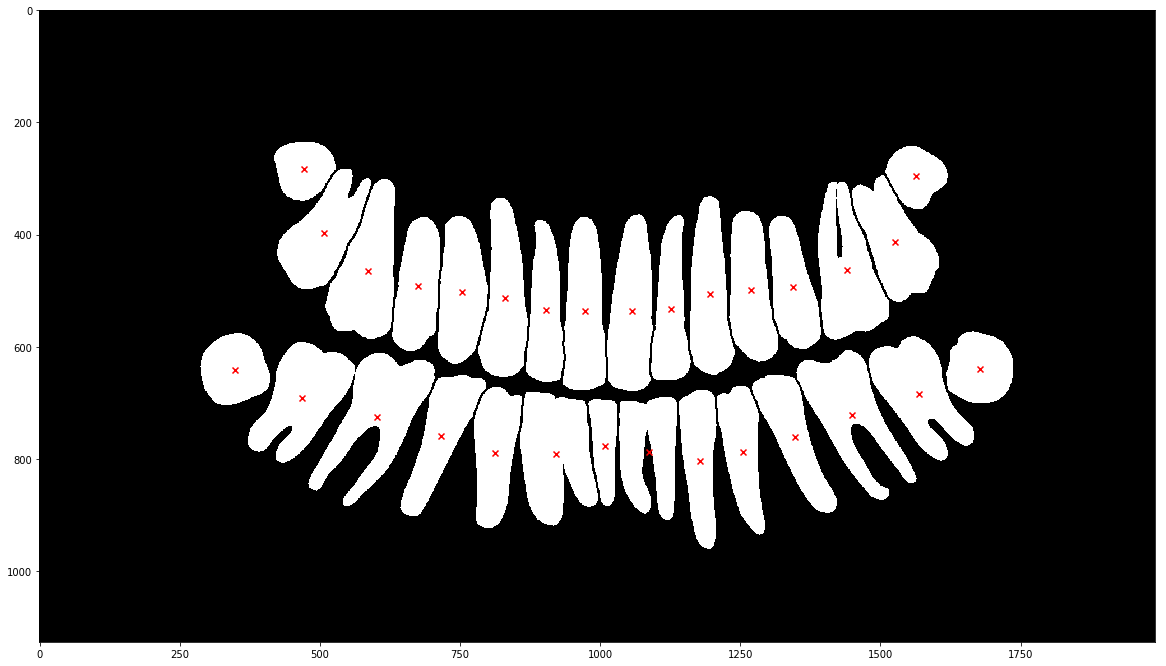

In [30]:
# Displaying an arbitrary mask with the corresponding computed center of mass
plt.figure(figsize=(20,20))
n_file = 275
file = file_list[n_file]
img = plt.imread(DATASET_PATH + '/' + file)
plt.imshow(img)
centers = np.array(CoMs[file])
plt.scatter(centers[:,0], centers[:,1], marker='x', color='red')

In [31]:
def sort_teeth(dentier):
    """sorts teeth by finding the down- and right-most tooth
    then finding the nearest neighbor iteratively
    """
    N = len(dentier)
    indices = []
    dist = np.sum(np.abs(dentier),axis=1)
    indices.append(np.argmax(dist))
    for i in range(N//2-1):
        s = np.inf
        mini = 0
        for j in range(N):
            norm = np.linalg.norm(dentier[indices[-1]] - dentier[j])
            if norm < s and (j not in indices):
                mini = j
                s = norm
        indices.append(mini)
    dist = np.sum(np.abs(dentier),axis=1)
    indices.append(np.argmin(dist))
    for i in range(N//2+1, N):
        s = np.inf
        mini = 0
        for j in range(N):
            norm = np.linalg.norm(dentier[indices[-1]] - dentier[j])
            if norm < s and (j not in indices):
                mini = j
                s = norm
        indices.append(mini)
    return indices

In [32]:
sorted_centers = sort_teeth(centers)
lower_teeth = centers[sorted_centers[:14]]
upper_teeth = centers[sorted_centers[14:]]

---
## Using quadratic fit

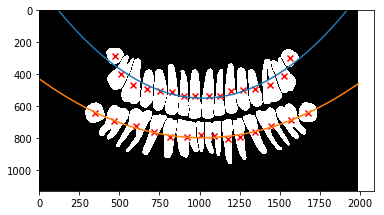

In [33]:
from numpy.polynomial.polynomial import Polynomial
plt.imshow(img)
plt.scatter(centers[:,0], centers[:,1], marker='x', color='red')
xx = np.linspace(0, img.shape[1])
upper_pol = Polynomial.fit(upper_teeth[:,0], upper_teeth[:,1], [0, 1, 2])
yy = upper_pol(xx)
plt.plot(xx, yy)
lower_pol = Polynomial.fit(lower_teeth[:,0], lower_teeth[:,1], [0, 1, 2])
yy = lower_pol(xx)
plt.plot(xx, yy)
plt.gca().set_ylim(img.shape[0], 0);

In [34]:
lower_min = -lower_pol.convert().coef[1]/2/lower_pol.convert().coef[2]
upper_min = -upper_pol.convert().coef[1]/2/upper_pol.convert().coef[2]
x_mean = (lower_min + upper_min)/2
y_gap = upper_min - lower_min

In [35]:
from numpy.polynomial.polynomial import Polynomial

def transform_quad(centers, gap = 1, x_scale = 1):
    # Unfit because some x-rays display no curvature so fitting a quadratic
    # is ill-conditioned
    assert len(centers) == 32
    sorted_centers = sort_teeth(centers)
    lower_teeth = centers[sorted_centers[:16]]
    upper_teeth = centers[sorted_centers[16:]]
    upper_pol = Polynomial.fit(upper_teeth[:,0], upper_teeth[:,1], [0, 2])
    lower_pol = Polynomial.fit(lower_teeth[:,0], lower_teeth[:,1], [0, 2])
    lower_min = -lower_pol.convert().coef[1]/2/lower_pol.convert().coef[2]
    upper_min = -upper_pol.convert().coef[1]/2/upper_pol.convert().coef[2]
    x_mean = (lower_min + upper_min)/2
    y_lower_mean = lower_pol(x_mean)
    y_gap = upper_min - lower_min
    centers = centers - (x_mean, y_lower_mean)
    
    centers[:,1] /= y_gap
    # Normalize horizontally by the order coefficient of the polynomial
    centers[:,0] /= np.sqrt(np.abs(lower_pol.convert().coef[2]))
    
    return centers, (x_mean, y_lower_mean)

(766.5407519920682, 739.4740853254016)

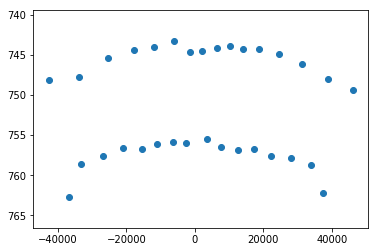

In [36]:
tooth_index = 1
centers = np.array(CoMs[_32_teeth[tooth_index]])
img = plt.imread(DATASET_PATH + '/' + _32_teeth[tooth_index])
transf_centers, shift = transform_quad(centers)
transf_centers += shift
plt.scatter(transf_centers[:,0],transf_centers[:,1])
plt.gca().set_ylim(
    max(transf_centers[:,1]) + 0.2*(max(transf_centers[:,1]) - min(transf_centers[:,1])),
    min(transf_centers[:,1]) - 0.2*(max(transf_centers[:,1]) - min(transf_centers[:,1]))
)

---
## Robust

In [37]:
from scipy.stats import trim_mean, iqr

def transform_robust(centers):
    """Transforms a set of teeth by centering and scaling
    The x-axis mean is found using the 0.2-trimmed mean,
    the y-axis shift is the bottom of the jaw (quite robust as lots 
    of teeth are at the same). The scaling on the x-axis is done via
    IQR (Inter Quartile Range) and on the y-axis using the
    difference between max and min on the y-axis.
    """
    centers = centers.astype('float64')
    x_mean = trim_mean(centers[:,0], 0.2)
    x_iqr = iqr(centers[:,0])
    centers[:,0] -= x_mean
    centers[:,0] /= x_iqr
    y_max = np.max(centers[:,1])
    y_min = np.min(centers[:,1])
    centers[:,1] -= y_min
    centers[:,1] /= (y_max - y_min)
    return centers, (x_mean, y_min), (x_iqr, (y_max - y_min))

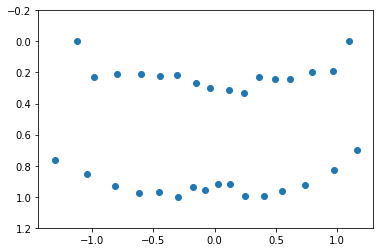

In [38]:
tooth_index = 2
centers = np.array(CoMs[_32_teeth[tooth_index]])
img = plt.imread(DATASET_PATH + '/' + _32_teeth[tooth_index])
rob_centers, shift, scale = transform_robust(centers)
plt.scatter(rob_centers[:,0], rob_centers[:,1])
plt.gca().set_ylim(1.2, -0.2);

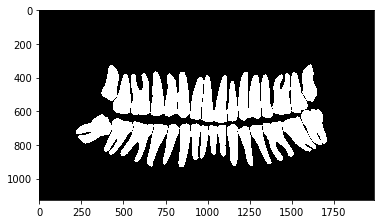

In [39]:
plt.imshow(img)

In [40]:
## Computes the mean set of teeth on complete jaws (32 teeth)

transformed_centers = []
mean = np.zeros((32,2))
for file in _32_teeth:
    centers = np.array(CoMs[file])
    sorted_centers = centers[sort_teeth(centers)]
    rob_centers, shift, scale = transform_robust(sorted_centers)
    transformed_centers.append(rob_centers)
    mean += rob_centers
mean /= len(_32_teeth)

Text(0.5, 1.0, 'Machoire moyenne')

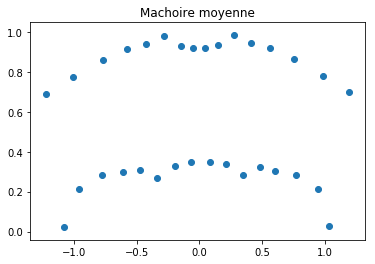

In [41]:
plt.scatter(mean[:,0], mean[:,1])
plt.title("Machoire moyenne")

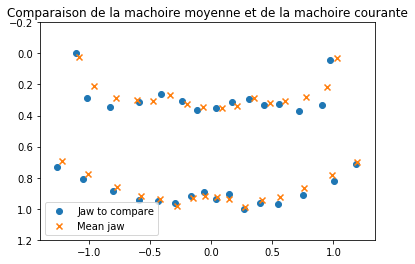

In [42]:
tooth_ind = 2
img = plt.imread(DATASET_PATH + '/' + not_32_teeth[tooth_ind])
transf, _, _ = transform_robust(np.array(CoMs[not_32_teeth[tooth_ind]]))
plt.scatter(transf[:,0], transf[:,1], label="Jaw to compare")
plt.scatter(mean[:,0], mean[:,1], marker='x', label="Mean jaw")
plt.gca().set_ylim(1.2, -0.2);
plt.title("Comparaison de la machoire moyenne et de la machoire courante");
plt.legend();

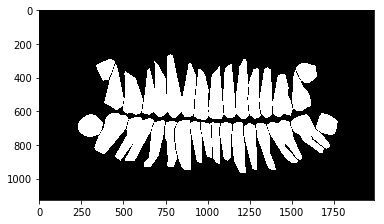

In [43]:
plt.imshow(img)

---
# Basin hopping

In [44]:
from scipy.spatial.distance import cdist

def J(p, R, C, N, nC, lamb, r):
    return (
        lamb*np.sum(np.square(np.linalg.norm(p-R, axis=1)))
        + (1-lamb)*np.sum(np.square(np.clip(cdist(p, C).flatten(), 0, 0.5)))
    )

In [45]:
lamb = 0.9
r = 0.10

tooth_ind = 0
img = plt.imread(DATASET_PATH + '/' + _32_teeth[tooth_ind])
transf, _, _ = transform_robust(np.array(CoMs[_32_teeth[tooth_ind]]))

centroids = transf
reference = mean

J_flat = lambda x: J(x.reshape((len(x)//2, 2)), reference, centroids, len(reference), len(centroids), lamb, r)

In [46]:
from scipy.optimize import basinhopping

init_pos = mean.reshape((64,1))

res = basinhopping(J_flat, init_pos, T=0.1, stepsize=0.01, disp=True)
# print(res)

basinhopping step 0: f 22.2389
basinhopping step 1: f 22.236 trial_f 22.236 accepted 1  lowest_f 22.236
found new global minimum on step 1 with function value 22.236
basinhopping step 2: f 22.2349 trial_f 22.2349 accepted 1  lowest_f 22.2349
found new global minimum on step 2 with function value 22.2349
basinhopping step 3: f 22.2349 trial_f 22.2349 accepted 1  lowest_f 22.2349
basinhopping step 4: f 22.2349 trial_f 22.2349 accepted 1  lowest_f 22.2349
found new global minimum on step 4 with function value 22.2349
basinhopping step 5: f 22.2349 trial_f 22.2349 accepted 1  lowest_f 22.2349
basinhopping step 6: f 22.2255 trial_f 22.2255 accepted 1  lowest_f 22.2255
found new global minimum on step 6 with function value 22.2255
basinhopping step 7: f 22.2255 trial_f 22.2255 accepted 1  lowest_f 22.2255
found new global minimum on step 7 with function value 22.2255
basinhopping step 8: f 22.2255 trial_f 22.2255 accepted 1  lowest_f 22.2255
basinhopping step 9: f 22.2255 trial_f 22.2255 acc

basinhopping step 96: f 22.2251 trial_f 22.2251 accepted 1  lowest_f 22.2251
basinhopping step 97: f 22.2251 trial_f 22.2251 accepted 1  lowest_f 22.2251
basinhopping step 98: f 22.2251 trial_f 22.2251 accepted 1  lowest_f 22.2251
basinhopping step 99: f 22.2251 trial_f 22.2251 accepted 1  lowest_f 22.2251
adaptive stepsize: acceptance rate 0.990000 target 0.500000 new stepsize 0.0123457 old stepsize 0.0111111
basinhopping step 100: f 22.2142 trial_f 22.2142 accepted 1  lowest_f 22.2142
found new global minimum on step 100 with function value 22.2142


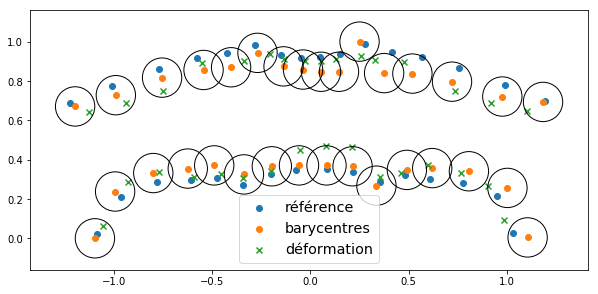

In [47]:
coords = res.x.reshape(reference.shape)
plt.figure(figsize=(10, 6))
plt.scatter(reference[:,0], reference[:,1], label="référence")
plt.scatter(centroids[:,0], centroids[:,1], label="barycentres")
ax = plt.gca()
for i in range(len(centroids)):
     ax.add_patch(plt.Circle(centroids[i,:], radius=r, fill=False))
plt.axis('scaled');

plt.scatter(coords[:,0], coords[:,1], marker='x', label="déformation")
plt.legend(fontsize='x-large')

Mode collapse :'(

---
## Elastic net

In [48]:
from scipy.spatial.distance import cdist

# The matrix Kij is equal to 1 if i and j share an edge
Kij = np.zeros((32,32))
for i in range(1,16):
    Kij[i-1,i] = 1 # Upper jaw
    Kij[16+i-1,16+i] = 1 # Lower jaw
for i in range(Kij.shape[0]//2):
    Kij[i,31-i] = 1
# L is the matrix of distances between every point of the mean jaw
L = cdist(mean, mean)

def K(P, Kij, L, C, lamb=0.5, d_clip=np.inf):
    # Assume R is sorted
    cross_dist = cdist(P, C)
    squared = np.square(np.clip(cross_dist.flatten(), 0, d_clip).reshape(cross_dist.shape))
    return (
        lamb*np.sum(np.multiply(Kij, np.square(cdist(P, P) - L)))
        + (1-lamb)*np.sum(np.min(squared, axis=1))
    )

In [49]:
# Helper list to retrieve jaws that have less than 32 teeth
# and visualize 'tricky' examples conveniently
CoMs_length = []
for key in CoMs.keys():
    CoMs_length.append([key, len(CoMs[key])])
CoMs_length.sort(key=lambda x: x[1])

In [50]:
# Parameters

lamb = 0.5
r = 0.05

tooth_ind = 1
img = plt.imread(DATASET_PATH + '/' + CoMs_length[tooth_ind][0])
transf, _, _ = transform_robust(np.array(CoMs[CoMs_length[tooth_ind][0]]))

centroids = transf
reference = mean

K_flat = lambda x: K(x.reshape((len(x)//2, 2)), Kij, L, centroids, lamb=0.5, d_clip=0.25)

In [51]:
# Actual optimization

from scipy.optimize import minimize

init_pos = mean.reshape((64,1))

res = minimize(K_flat, init_pos, method='BFGS')
print(res.message)

Optimization terminated successfully.


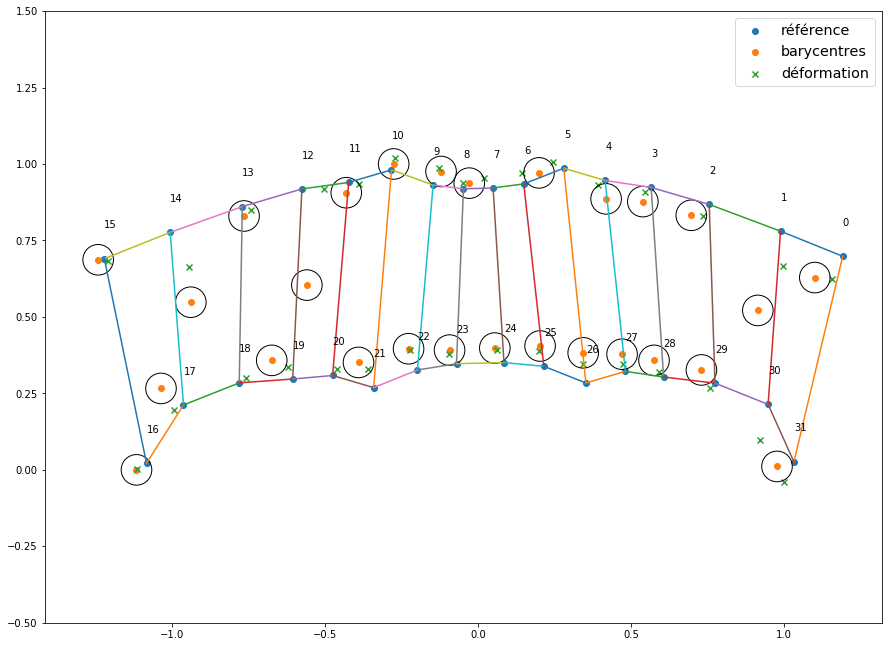

In [52]:
coords = res.x.reshape(reference.shape)
plt.figure(figsize=(15, 15))
plt.scatter(reference[:,0], reference[:,1], label="référence")
plt.scatter(centroids[:,0], centroids[:,1], label="barycentres")
for i in range(len(reference)):
    plt.text(reference[i,0], reference[i,1]+0.1, str(i))
for i in range(Kij.shape[0]):
    for j in range(Kij.shape[1]):
        if Kij[i,j] == 1:
            plt.plot([reference[i,0], reference[j,0]], [reference[i,1], reference[j,1]], '-')
ax = plt.gca()
for i in range(len(centroids)):
     ax.add_patch(plt.Circle(centroids[i,:], radius=r, fill=False))
plt.axis('scaled');

plt.scatter(coords[:,0], coords[:,1], marker='x', label="déformation")
plt.legend(fontsize='x-large')
ax.set_ylim(-0.5, 1.5);

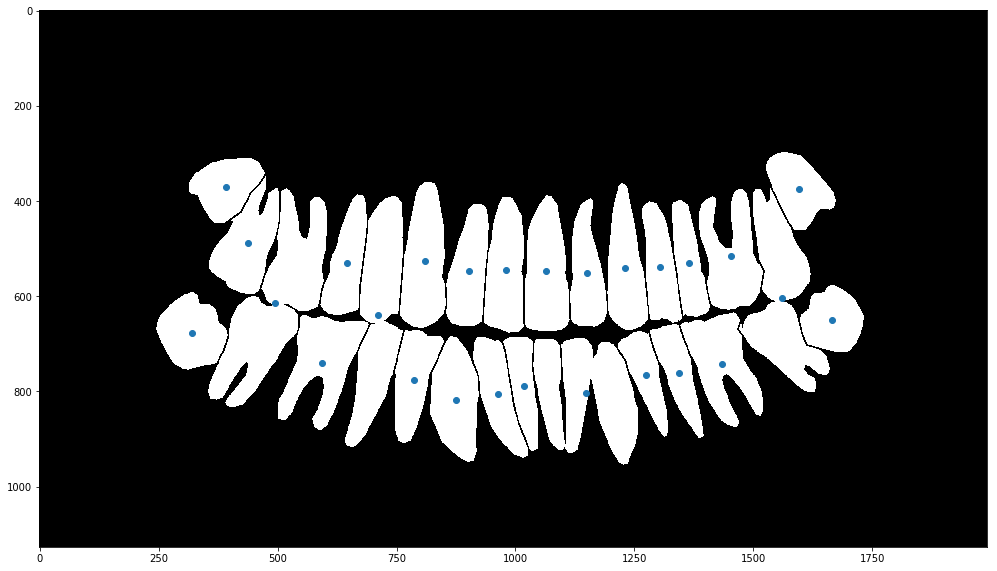

In [53]:
img_ratio = img.shape[0]/img.shape[1]
plt.figure(figsize=(30*img_ratio,30))
plt.imshow(img)
plt.scatter(np.array(CoMs[CoMs_length[tooth_ind][0]])[:,0], np.array(CoMs[CoMs_length[tooth_ind][0]])[:,1], label="référence")

---
## Illustration of "mode surfing"

In [54]:
xx = np.linspace(0, 20, 200)
threes = 2*np.ones((200, 2))
threes[:,1] = 0.25*np.square(xx-4)
yy1 = np.min(threes, axis=1)
threes = 2*np.ones((200, 2))
threes[:,1] = 0.25*np.square(xx-8)
yy2 = np.min(threes, axis=1)
yyt = yy1 + yy2
yy_sol = np.min(np.concatenate((yy1.reshape((200,1)), yy2.reshape((200,1))), axis=1), axis=1)-0.1

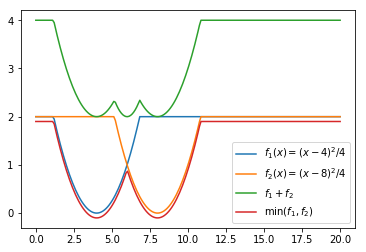

In [55]:
plt.plot(xx, yy1, label="$f_1(x) = (x-4)^2/4$")
plt.plot(xx, yy2, label="$f_2(x) = (x-8)^2/4$")
plt.plot(xx, yyt, label="$f_1 + f_2$")
plt.plot(xx, yy_sol, label="$\min(f_1, f_2)$")
plt.legend()